In [ ]:
!git clone https://github.com/intelpro/Samsung_TAsession/
%cd Samsung_TAsession/PSMnet/
!ls
!mkdir saved_model
from google.colab import drive
drive.mount('/content/gdrive/')
datapath = '/content/gdrive/My Drive/samsung_TAsession/KITTI_2015/training/'
savemodel = './saved_model'

## import로 모듈 가져오기
### torch에 있는 module, 우리가 사전에 정의해놓았던 함수 등 import로 가져온다. 

In [1]:
from __future__ import print_function 
import torch 
import torch.nn as nn 
import torch.utils.data 
from torch.autograd import Variable 
import torch.nn.functional as F
import torch.optim as optim
import torch
import matplotlib.pyplot as plt
import time
from submodule import *
from preprocess import *
from dataloader import listflowfile as lt
from dataloader.KITTILoader import *
from dataloader.KITTIloader2015 import *

## PSMnet
### PSMnet 생성자 정의하기
#### 1단계: feature extraction part 정의하기
#### 2단계: 3D convolution part 정의하기
#### 3단계: weight initialization 하기
### PSMnet forward 함수 정의하기
#### 1단계: left, right 이미지에서 feature extraction을 수행한다. 
#### 2단계: cost volume을 만든다.  + left, right feature map을 cost volume의 형태에 맞게 만들어준다
#### 3단계: 3D convolution을 통해서 cost volume의 refinement를 수행한다. 
#### 4단계: disparity regression을 수행한다.

In [2]:
class PSMNet(nn.Module):
    def __init__(self, maxdisp):
        super(PSMNet, self).__init__()
        self.maxdisp = maxdisp
        ############# 1단계: feature extraction part 정의하기 #############
        self.feature_extraction = feature_extraction()
        ############# 1단계 end #############
        ############# 2단계: 3D convolution part 정의하기 #############
        self.dres0 = nn.Sequential(convbn_3d(64, 32, 3, 1, 1),
                                   nn.ReLU(inplace=True),
                                   convbn_3d(32, 32, 3, 1, 1),
                                   nn.ReLU(inplace=True))

        self.dres1 = nn.Sequential(convbn_3d(32, 32, 3, 1, 1),
                                   nn.ReLU(inplace=True),
                                   convbn_3d(32, 32, 3, 1, 1)) 

        self.dres2 = nn.Sequential(convbn_3d(32, 32, 3, 1, 1),
                                   nn.ReLU(inplace=True),
                                   convbn_3d(32, 32, 3, 1, 1))
 
        self.dres3 = nn.Sequential(convbn_3d(32, 32, 3, 1, 1),
                                   nn.ReLU(inplace=True),
                                   convbn_3d(32, 32, 3, 1, 1)) 

        self.dres4 = nn.Sequential(convbn_3d(32, 32, 3, 1, 1),
                                   nn.ReLU(inplace=True),
                                   convbn_3d(32, 32, 3, 1, 1)) 
 
        self.classify = nn.Sequential(convbn_3d(32, 32, 3, 1, 1),
                                      nn.ReLU(inplace=True),
                                      nn.Conv3d(32, 1, kernel_size=3, padding=1, stride=1,bias=False))
        ############ 2단계 end ###########
        ############# 3단계: weight initialization #############
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
            elif isinstance(m, nn.Conv3d):
                n = m.kernel_size[0] * m.kernel_size[1]*m.kernel_size[2] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()
            elif isinstance(m, nn.BatchNorm3d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()
            elif isinstance(m, nn.Linear):
                m.bias.data.zero_()
        ############# 3단계 end #############
        
    #### forward 함수 정의하기 ####
    def forward(self, left, right):
        ############# 1단계: left, right image로 부터 각각 feature extraction을 수행한다. #############
        refimg_fea     = self.feature_extraction(left)
        targetimg_fea  = self.feature_extraction(right)
 
        ############# 2단계: cost volume을 만든다. #############
        ############# cost volume의 사이즈는 Batch size x 2*Feature map size, disparity range/4, W, H #############
        cost = Variable(torch.FloatTensor(refimg_fea.size()[0], refimg_fea.size()[1]*2, self.maxdisp//4,  \
                                          refimg_fea.size()[2],  refimg_fea.size()[3]).zero_(), \
                                          volatile= not self.training).cuda()
        ############# 2단계: left, right feature map을 cost volume의 형태에 맞게 만들어준다. #############
        ############# 5D cost volume에서 두번째 차원(Feature map size)의 한쪽에는 reference image #############
        ############# 다른 한쪽에서는 target image를 넣어준다. #############

        for i in range(self.maxdisp//4):
            if i > 0 :
                cost[:, :refimg_fea.size()[1], i, :,i:]   = refimg_fea[:,:,:,i:]
                cost[:, refimg_fea.size()[1]:, i, :,i:] = targetimg_fea[:,:,:,:-i]
            else:
                cost[:, :refimg_fea.size()[1], i, :,:]   = refimg_fea
                cost[:, refimg_fea.size()[1]:, i, :,:]   = targetimg_fea
        ############# 3단계: cost volume의 refinement를 수행한다. #############
        cost = cost.contiguous()

        cost0 = self.dres0(cost)
        cost0 = self.dres1(cost0) + cost0
        cost0 = self.dres2(cost0) + cost0 
        cost0 = self.dres3(cost0) + cost0 
        cost0 = self.dres4(cost0) + cost0
        ############# 4단계: disparity regression을 수행한다. #############
        cost = self.classify(cost0)
        cost = F.upsample(cost, [self.maxdisp,left.size()[2],left.size()[3]], mode='trilinear')
        cost = torch.squeeze(cost,1)
        pred = F.softmax(cost)
        pred = disparityregression(self.maxdisp)(pred)
        return pred

## main 함수
### 각종 hyperparameter들과 dataset 경로들을 지정한다. 
### model을 정의하고 gpu상에 올려준다. 
### optimizer를 정의한다. 
### model을 print하면 우리가 정의했던 model들의 module들을 볼 수 있다. 

In [3]:
if __name__=='__main__':
    max_disp = 192
    epochs = 20
    model = PSMNet(max_disp)
    model = model.cuda()
    optimizer = optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.999))
    print(model)

PSMNet(
  (feature_extraction): feature_extraction(
    (firstconv): Sequential(
      (0): Sequential(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): ReLU(inplace)
      (2): Sequential(
        (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (3): ReLU(inplace)
      (4): Sequential(
        (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (5): ReLU(inplace)
    )
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Sequential(
          (0): Sequential(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=F

## Get dataset string
### data path 내에 있는 left image, right image, disparity 등의 string을 가져온다.

In [4]:
    all_left_img, all_right_img, all_left_disp, test_left_img, test_right_img, test_left_disp = dataloader(datapath)
    print('left image string:', all_left_img[0])
    print('right image string: ', all_right_img[0])
    print('left disparity string: ', all_left_disp[0])
    print('test left image string: ',test_left_img[0])
    print('test right image string: ', test_right_img[0])

left image string: /media/dataset/KITTI_2015/training/image_2/000090_10.png
right image string:  /media/dataset/KITTI_2015/training/image_3/000090_10.png
left disparity string:  /media/dataset/KITTI_2015/training/disp_occ_0/000090_10.png
test left image string:  /media/dataset/KITTI_2015/training/image_2/000058_10.png
test right image string:  /media/dataset/KITTI_2015/training/image_3/000058_10.png


## Define dataloader
### image string정보를 사용하여 dataloader를 정의한다. 

In [5]:
    KITTI_dataset_train = myImageFloder(all_left_img,all_right_img,all_left_disp, True)
    TrainImgLoader = torch.utils.data.DataLoader(KITTI_dataset_train, 
         batch_size= 3, shuffle= True, num_workers= 8, drop_last=False)
    print('Train object: ', TrainImgLoader)
    KITTI_dataset_test = myImageFloder(test_left_img, test_right_img, test_left_disp, True)
    TestImgLoader = torch.utils.data.DataLoader(KITTI_dataset_test, \
                    batch_size=8, shuffle= False, num_workers= 4, drop_last=False)
    print('Test object: ', TestImgLoader)

Train object:  <torch.utils.data.dataloader.DataLoader object at 0x7f57ab091240>
Test object:  <torch.utils.data.dataloader.DataLoader object at 0x7f57ab0912b0>


## Check KITTI dataset data
### 우리가 정의한 KITTI dataset 정보를 사용하여 image들을 plot 해봅니다.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


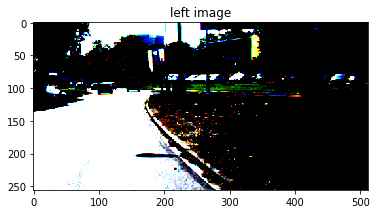

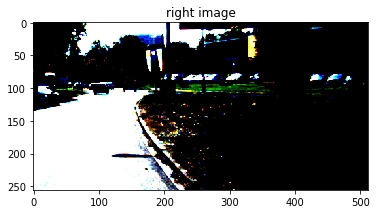

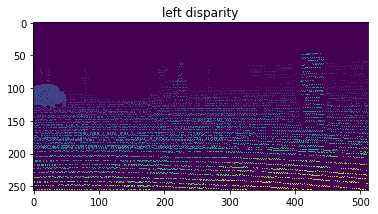

In [6]:
    left_img, right_img, left_disp = KITTI_dataset_train.__getitem__(0)
    plt.figure()
    plt.title('left image')
    plt.imshow(left_img.detach().cpu().numpy().transpose(1,2,0))
    plt.figure()
    plt.title('right image')
    plt.imshow(right_img.detach().cpu().numpy().transpose(1,2,0))
    plt.figure()
    plt.title('left disparity')
    plt.imshow(left_disp)

In [ ]:
    for epoch in range(0, epochs):
        total_train_loss = 0
        print('This is %d-th epoch' %(epoch))
        model.train()
        #------------- Train ------------------------------------------------------------
        for batch_idx, (imgL_crop, imgR_crop, disp_crop_L) in enumerate(TrainImgLoader):
            imgL_crop, imgR_crop, disp_crop_L = imgL_crop.cuda(), imgR_crop.cuda(), disp_crop_L.cuda()
            mask = disp_crop_L < max_disp
            mask.detach_()
            start_time = time.time()
            output = model(imgL_crop, imgR_crop)
            output = torch.squeeze(output,1)
            loss = F.smooth_l1_loss(output[mask], disp_crop_L[mask], size_average=True)
            loss.backward()
            total_train_loss += loss.detach().item()
            optimizer.step()
            if batch_idx % 3 == 0:
                print('Iter %d training loss = %.3f , time = %.2f' %(batch_idx, loss, time.time() - start_time))
        print('epoch %d total training loss = %.3f' %(epoch, total_train_loss/len(TrainImgLoader)))
        #SAVE
        savefilename = savemodel+'/checkpoint_'+str(epoch)+'.tar'
        torch.save({
            'epoch': epoch,
            'state_dict': model.state_dict(),
            'train_loss': total_train_loss/len(TrainImgLoader),
         }, savefilename)
        #------------- TEST ------------------------------------------------------------
        total_test_loss = 0
        for batch_idx, (imgL, imgR, disp_L) in enumerate(TestImgLoader):
            test_loss, disp = test(model, imgL,imgR, disp_L)
            print('Iter %d test loss = %.3f' %(batch_idx, test_loss))
            total_test_loss += test_loss
        print('total test loss = %.3f' %(total_test_loss/len(TestImgLoader)))

This is 0-th epoch


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1961: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:86: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='elementwise_mean' instead.
  warnings.warn(warning.format(ret))


Iter 0 training loss = 83.445 , time = 1.01
Iter 3 training loss = 8.380 , time = 0.94
Iter 6 training loss = 10.171 , time = 0.94
Iter 9 training loss = 6.052 , time = 0.98
Iter 12 training loss = 4.122 , time = 0.94
Iter 15 training loss = 6.427 , time = 0.94
Iter 18 training loss = 4.306 , time = 0.94
Iter 21 training loss = 5.428 , time = 0.94
Iter 24 training loss = 6.243 , time = 0.94
Iter 27 training loss = 6.852 , time = 0.94
Iter 30 training loss = 4.752 , time = 0.94
Iter 33 training loss = 7.692 , time = 0.94
Iter 36 training loss = 7.362 , time = 0.94
Iter 39 training loss = 9.218 , time = 0.94
Iter 42 training loss = 6.686 , time = 0.97
Iter 45 training loss = 8.213 , time = 0.94
Iter 48 training loss = 3.093 , time = 0.94
Iter 51 training loss = 5.275 , time = 0.94
epoch 0 total training loss = 9.422


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:62: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.


Iter 0 test loss = 8.411
Iter 1 test loss = 6.265
Iter 2 test loss = 8.708
Iter 3 test loss = 8.765
Iter 4 test loss = 5.584
total test loss = 7.547
This is 1-th epoch
Iter 0 training loss = 5.902 , time = 0.99
Iter 3 training loss = 7.394 , time = 0.94
Iter 6 training loss = 5.940 , time = 0.94
Iter 9 training loss = 10.612 , time = 1.04
Iter 12 training loss = 6.513 , time = 0.97
Iter 15 training loss = 8.849 , time = 1.02
Iter 18 training loss = 6.675 , time = 0.97
Iter 21 training loss = 6.424 , time = 0.94
Iter 24 training loss = 4.941 , time = 0.94
Iter 27 training loss = 9.165 , time = 0.94
Iter 30 training loss = 7.783 , time = 0.95
Iter 33 training loss = 4.732 , time = 0.94
Iter 36 training loss = 5.413 , time = 0.94
Iter 39 training loss = 7.205 , time = 0.94
Iter 42 training loss = 7.865 , time = 0.95
